# Mentoria

### Hito 2 - Practico de Exploracion y Curacion



In [1]:
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from statusFixer import statusFixer
import datetime

#!pip install python-decouple
#from decouple import config
from sqlalchemy import create_engine, text

sns.set_context('talk')

### Cargamos el dataset completo con los montos

In [2]:
df_m19 = pd.read_csv("df_m19.csv")
df_m19.head()

,seg_id,prs_id,seg_codigo,hora,seg_usuario,obn_acreedor,obn_interno,obn_producto,obn_cabecera,fecha_alta,obn_estudio,estado,obn_id,monto_deuda,seg_count_codigo
0,19605119,787994,323,08/10/2019 11:00:00,341,269,1438679,102,9269,23/09/2019,1111,B,1438679,44121.12,805947
1,19605188,787994,8,08/10/2019 11:04:00,341,269,1438679,102,9269,23/09/2019,1111,B,1438679,44121.12,83107
2,19605113,787994,323,08/10/2019 10:59:00,341,269,1438679,102,9269,23/09/2019,1111,B,1438679,44121.12,805947
3,19734817,787994,330,12/10/2019 11:05:00,341,269,1438679,102,9269,23/09/2019,1111,B,1438679,44121.12,24553
4,19879460,787994,13,17/10/2019 10:56:00,341,269,1438679,102,9269,23/09/2019,1111,B,1438679,44121.12,30563


In [3]:
df_m19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913524 entries, 0 to 5913523
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   seg_id            int64  
 1   prs_id            int64  
 2   seg_codigo        int64  
 3   hora              object 
 4   seg_usuario       int64  
 5   obn_acreedor      int64  
 6   obn_interno       int64  
 7   obn_producto      int64  
 8   obn_cabecera      int64  
 9   fecha_alta        object 
 10  obn_estudio       int64  
 11  estado            object 
 12  obn_id            int64  
 13  monto_deuda       float64
 14  seg_count_codigo  int64  
dtypes: float64(1), int64(11), object(3)
memory usage: 676.7+ MB


Las columnas hora, fecha_alta y monto_deuda, hay que cambiarlas de tipo. Las dos primeras hay que pasarlas a date, la ultima a float64.

### Cambiamos el tipo de la variable monto_deuda

In [4]:
m19_df=df_m19.copy()
print(m19_df.monto_deuda.dtypes)

float64


Se observa que es float por que ya se cambio en el entregable anterior.

In [5]:
m19_df.monto_deuda.dtypes

dtype('float64')

### Cambiamos el tipo de las variables fecha_alta y hora

In [6]:
m19_df['hora'] = pd.to_datetime(m19_df['hora'], format='%d/%m/%Y %H:%M:%S')
m19_df['fecha_alta']  = pd.to_datetime(m19_df['fecha_alta'], format='%d/%m/%Y')

In [7]:
m19_df.hora.dtypes

dtype('<M8[ns]')

In [8]:
m19_df.fecha_alta.dtypes

dtype('<M8[ns]')

In [9]:
m19_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5913524 entries, 0 to 5913523
Data columns (total 15 columns):
 #   Column            Dtype         
---  ------            -----         
 0   seg_id            int64         
 1   prs_id            int64         
 2   seg_codigo        int64         
 3   hora              datetime64[ns]
 4   seg_usuario       int64         
 5   obn_acreedor      int64         
 6   obn_interno       int64         
 7   obn_producto      int64         
 8   obn_cabecera      int64         
 9   fecha_alta        datetime64[ns]
 10  obn_estudio       int64         
 11  estado            object        
 12  obn_id            int64         
 13  monto_deuda       float64       
 14  seg_count_codigo  int64         
dtypes: datetime64[ns](2), float64(1), int64(11), object(1)
memory usage: 676.7+ MB


### Datos Faltantes

Visualizamos si hay datos faltantes

<AxesSubplot:>

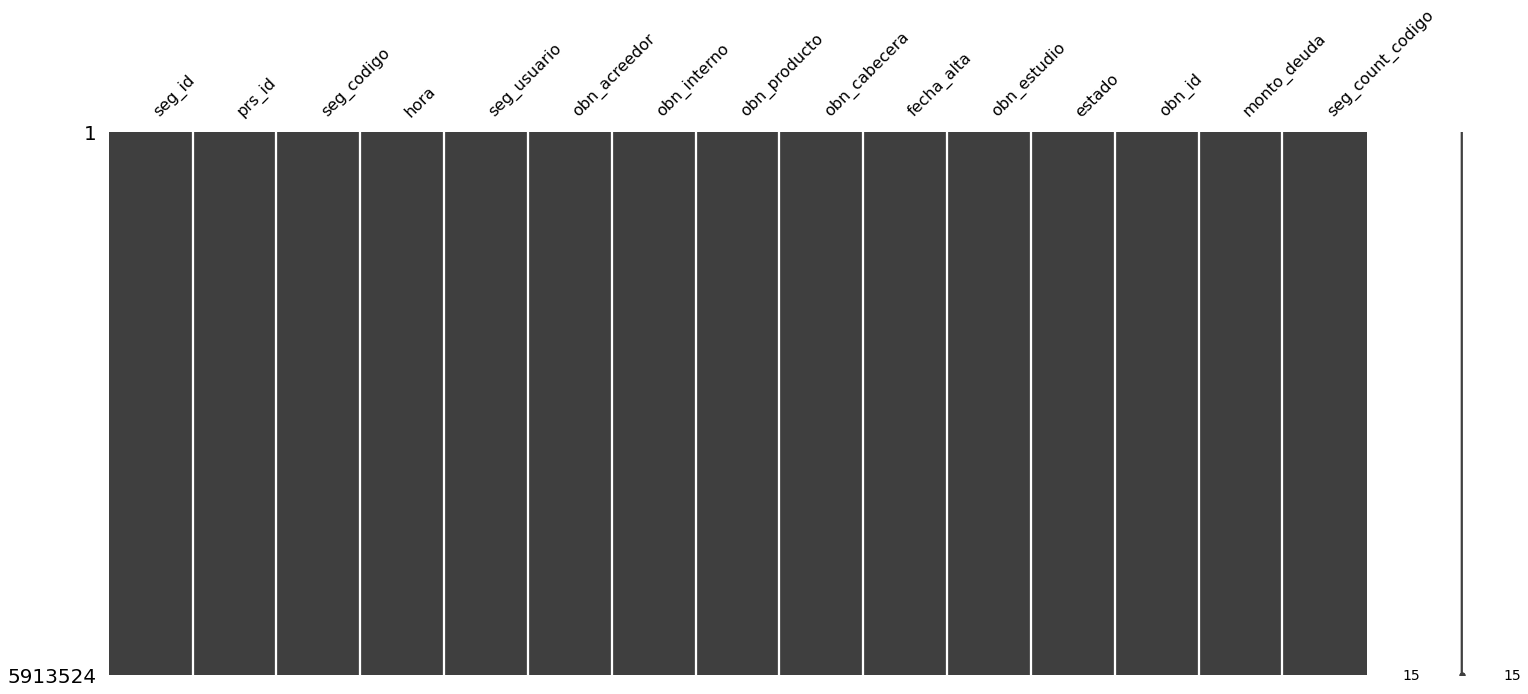

In [10]:
import missingno as msno
msno.matrix(m19_df)#.sample(10000,random_state=123));

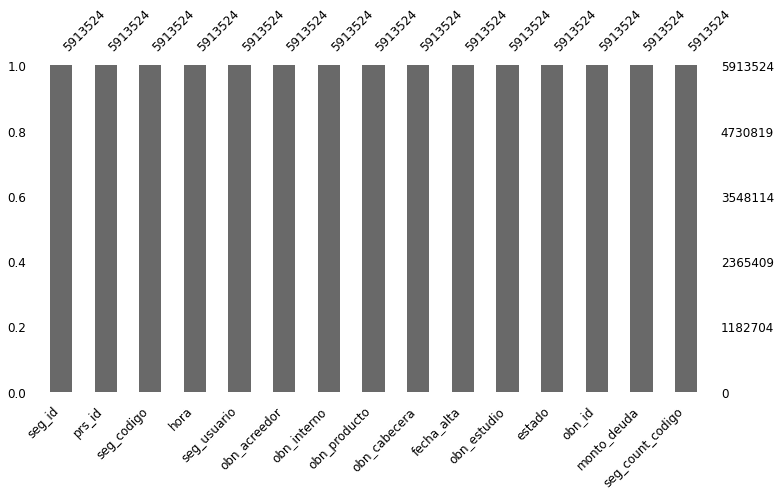

In [11]:
msno.bar(m19_df,figsize=(12, 6), sort="ascending",fontsize=12) ;

A simple vista no pareceria haber datos faltantes, procedemos a hacer un analisis de las variables para verificarlo.

### Atributos categoricos

Verificamos descriptivos basicos de la unica variable categorica **estado**

In [12]:
m19_df['estado'].apply(statusFixer).describe()

count     5913524
unique          6
top             B
freq      3400004
Name: estado, dtype: object

In [13]:
m19_df['estado'] = m19_df['estado'].apply(statusFixer)
m19_df.estado

0          B
1          B
2          B
3          B
4          B
          ..
5913519    A
5913520    A
5913521    A
5913522    A
5913523    A
Name: estado, Length: 5913524, dtype: object

Se hace un one-hot encoding de la misma para poder trabajarla posteriormente

In [14]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
estado_1hot = cat_encoder.fit_transform(m19_df[['estado']])
estado_1hot

<5913524x6 sparse matrix of type '<class 'numpy.float64'>'
	with 5913524 stored elements in Compressed Sparse Row format>

In [15]:
estado_1hot.toarray()

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [16]:
cat_encoder.categories_

[array(['A', 'B', 'C', 'L', 'O', 'R'], dtype=object)]

### Atributos numericos, numericos ordinales y datetimes

Ploteamos histogramas para ver la distribucion y la relacion con los descriptivos. Mas que nada es para verificar que no haya datos faltantes y que el valor de los descriptivos se refleje en la distribucion ya que el unico que tendria valor estadistico es el de montos.

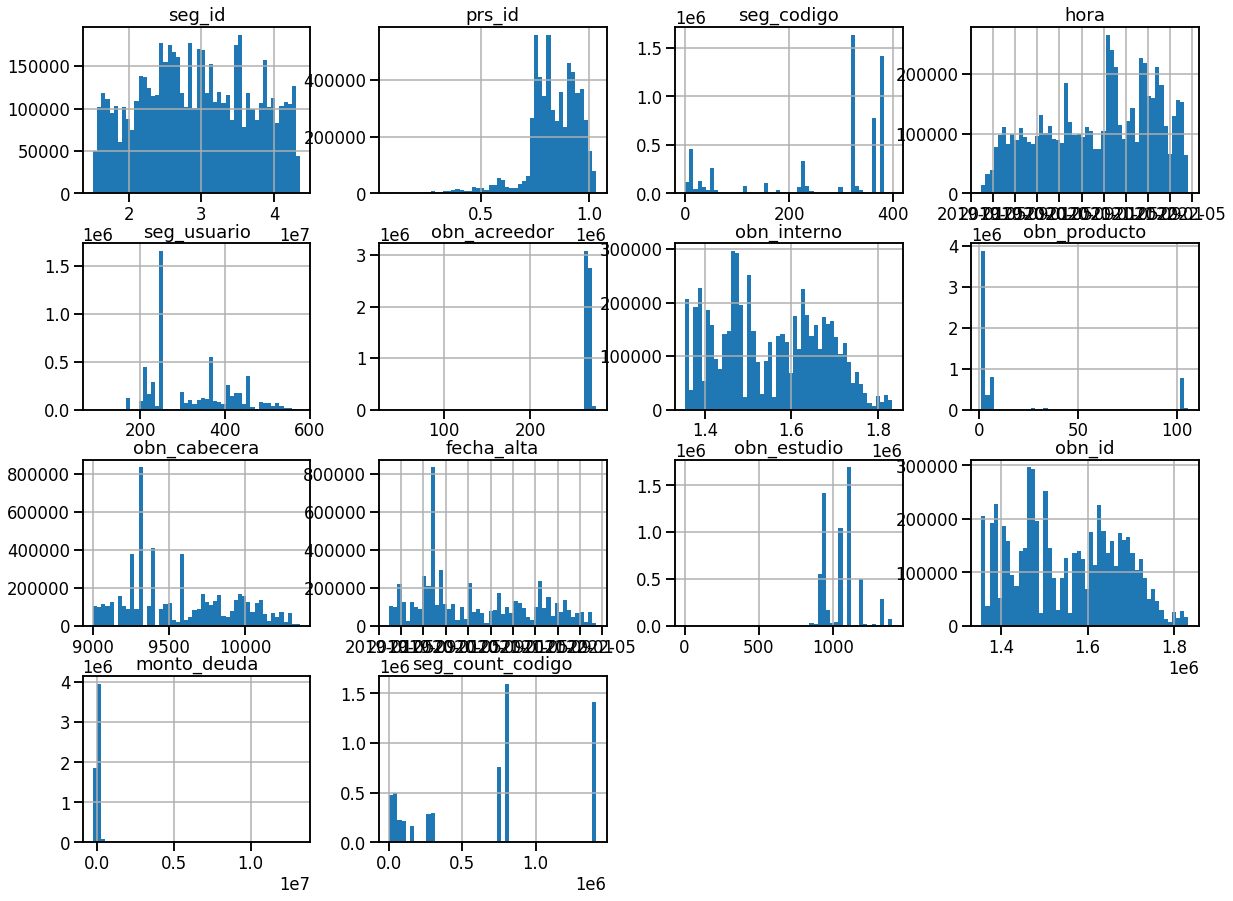

In [17]:
%matplotlib inline 
import matplotlib.pyplot as plt
m19_df.hist(bins=50, figsize=(20,15))
plt.show()

In [18]:
m19_df.describe(datetime_is_numeric=True)

,seg_id,prs_id,seg_codigo,hora,seg_usuario,obn_acreedor,obn_interno,obn_producto,obn_cabecera,fecha_alta,obn_estudio,obn_id,monto_deuda,seg_count_codigo
count,5.913524e+06,5.913524e+06,5.913524e+06,5913524,5.913524e+06,5.913524e+06,5.913524e+06,5.913524e+06,5.913524e+06,5913524,5.913524e+06,5.913524e+06,5.913524e+06,5.913524e+06
mean,2.937981e+07,8.329688e+05,2.687117e+02,2020-12-02 16:09:03.726350848,3.216380e+02,2.661652e+02,1.552521e+06,1.628063e+01,9.571130e+03,2020-06-08 20:05:07.031548416,1.050061e+03,1.552521e+06,4.941941e+04,6.931374e+05
min,1.512041e+07,7.412500e+04,0.000000e+00,2019-02-26 15:30:00,8.800000e+01,3.600000e+01,1.354293e+06,1.000000e+00,9.002000e+03,2019-02-26 00:00:00,4.000000e+00,1.354293e+06,-2.561480e+05,1.000000e+00
25%,2.342830e+07,7.694000e+05,2.240000e+02,2020-03-26 17:08:50,2.480000e+02,2.640000e+02,1.458360e+06,1.000000e+00,9.323000e+03,2019-10-28 00:00:00,9.400000e+02,1.458360e+06,9.394640e+03,1.621470e+05
50%,2.925659e+07,8.401000e+05,3.260000e+02,2021-01-28 11:34:24,3.000000e+02,2.660000e+02,1.549135e+06,1.000000e+00,9.497000e+03,2020-03-05 00:00:00,1.042000e+03,1.549135e+06,2.792842e+04,7.913140e+05
75%,3.551017e+07,9.233420e+05,3.610000e+02,2021-08-18 15:56:57,4.030000e+02,2.690000e+02,1.653734e+06,6.000000e+00,9.863000e+03,2021-03-08 00:00:00,1.112000e+03,1.653734e+06,6.230407e+04,8.059470e+05
max,4.358401e+07,1.032616e+06,3.990000e+02,2022-04-11 14:50:56,5.770000e+02,2.770000e+02,1.833294e+06,1.060000e+02,1.036100e+04,2022-03-30 00:00:00,1.397000e+03,1.833294e+06,1.321812e+07,1.411916e+06
std,7.612513e+06,1.261360e+05,1.319535e+02,NaN,9.649782e+01,1.281414e+01,1.200378e+05,3.443077e+01,3.461101e+02,NaN,1.165093e+02,1.200378e+05,8.749170e+04,5.009831e+05


In [19]:
missing_values_count = m19_df.isna().sum()
missing_values_count

seg_id              0
prs_id              0
seg_codigo          0
hora                0
seg_usuario         0
obn_acreedor        0
obn_interno         0
obn_producto        0
obn_cabecera        0
fecha_alta          0
obn_estudio         0
estado              0
obn_id              0
monto_deuda         0
seg_count_codigo    0
dtype: int64

Se verifica que no hay datos faltantes

### Correlacion entre monto_deuda y los demas atributos

In [20]:
m19_df_sample = m19_df.sample(10000,random_state=123)
m19_df_sample

,seg_id,prs_id,seg_codigo,hora,seg_usuario,obn_acreedor,obn_interno,obn_producto,obn_cabecera,fecha_alta,obn_estudio,estado,obn_id,monto_deuda,seg_count_codigo
735330,23961110,801589,379,2020-04-20 20:02:18,206,264,1456524,1,9321,2019-10-25,940,B,1456524,106750.38,1411916
1232975,26747196,753560,361,2020-10-05 11:00:25,248,264,1383742,1,9123,2019-05-24,940,B,1383742,24690.81,758342
2345002,24260721,851217,326,2020-05-07 15:47:17,432,269,1536610,2,9479,2020-02-17,1192,B,1536610,62983.89,791314
3651426,41157225,806963,379,2022-01-25 16:50:52,248,270,1471265,2,9325,2019-10-28,1112,A,1471265,6828.62,1411916
2269302,38438863,777445,379,2021-10-25 15:45:05,248,268,1423296,2,9247,2019-08-29,1092,A,1423296,95946.00,1411916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855212,21250976,549335,323,2019-12-12 10:49:33,438,270,1467625,2,9324,2019-10-28,1112,A,1467625,96663.88,805947
882937,15276252,736225,237,2019-03-12 10:30:00,327,264,1354305,1,9002,2019-02-26,791,C,1354305,2600.00,29418
1139377,17184046,711288,361,2019-07-05 14:51:00,206,266,1373401,6,9079,2019-04-16,895,B,1373401,17855.82,758342
5907715,43076404,1031360,33,2022-03-26 13:36:06,440,264,1831250,1,10348,2022-03-23,901,A,1831250,74500.21,30898


In [21]:
corr_matrix = m19_df_sample.corr()
corr_matrix['monto_deuda'].sort_values(ascending=False)

monto_deuda         1.000000
obn_cabecera        0.221217
obn_interno         0.216051
obn_id              0.216051
prs_id              0.150314
seg_usuario         0.128231
obn_estudio         0.105506
seg_id              0.096189
obn_acreedor        0.040249
obn_producto        0.032551
seg_codigo          0.018318
seg_count_codigo   -0.002862
Name: monto_deuda, dtype: float64

Vemos que los valores de correlacion son bastante bajos. Tomamos los mas representativos y los ploteamos

array([[<AxesSubplot:xlabel='monto_deuda', ylabel='monto_deuda'>,
        <AxesSubplot:xlabel='obn_cabecera', ylabel='monto_deuda'>,
        <AxesSubplot:xlabel='obn_interno', ylabel='monto_deuda'>,
        <AxesSubplot:xlabel='prs_id', ylabel='monto_deuda'>],
       [<AxesSubplot:xlabel='monto_deuda', ylabel='obn_cabecera'>,
        <AxesSubplot:xlabel='obn_cabecera', ylabel='obn_cabecera'>,
        <AxesSubplot:xlabel='obn_interno', ylabel='obn_cabecera'>,
        <AxesSubplot:xlabel='prs_id', ylabel='obn_cabecera'>],
       [<AxesSubplot:xlabel='monto_deuda', ylabel='obn_interno'>,
        <AxesSubplot:xlabel='obn_cabecera', ylabel='obn_interno'>,
        <AxesSubplot:xlabel='obn_interno', ylabel='obn_interno'>,
        <AxesSubplot:xlabel='prs_id', ylabel='obn_interno'>],
       [<AxesSubplot:xlabel='monto_deuda', ylabel='prs_id'>,
        <AxesSubplot:xlabel='obn_cabecera', ylabel='prs_id'>,
        <AxesSubplot:xlabel='obn_interno', ylabel='prs_id'>,
        <AxesSubplot:xlabel='

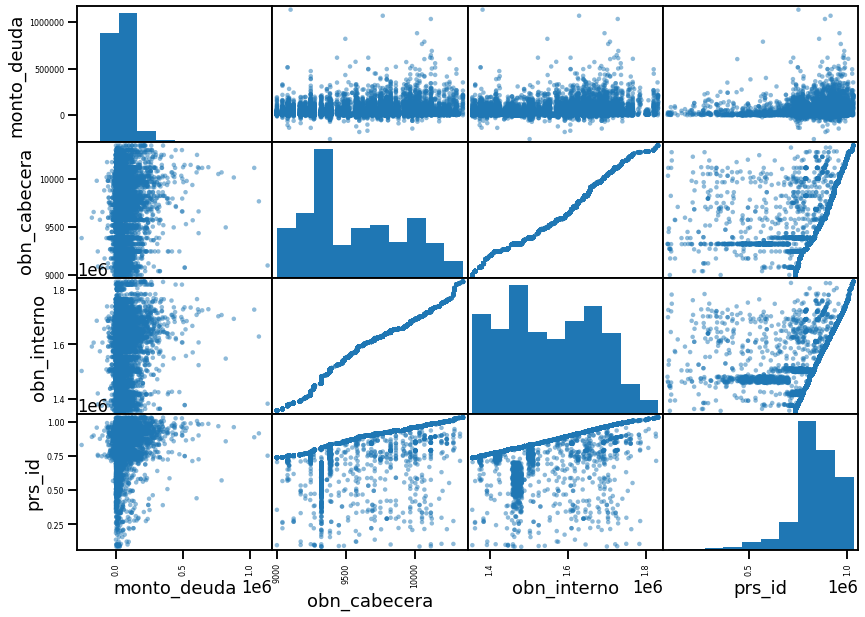

In [22]:
from pandas.plotting import scatter_matrix

attributes = ['monto_deuda', 'obn_cabecera', 'obn_interno', 'prs_id']

scatter_matrix(m19_df_sample[attributes], figsize=(14, 10))


Se observa que la correlacion de obn_cabecera, obn_interno y prs_id con monto_deuda siguen siendo muy poco representativas. Por otro lado se observa una alta correlacion entre obn_interno y obn_cabecera.

In [23]:
m19_df['count_gestion'] = m19_df['obn_interno'].map(m19_df['obn_interno'].value_counts())

### Individuos que se repiten en los distintos años

In [24]:
prs_2019 = set(m19_df[(m19_df['hora']>'2019-01-01 00:00') & (m19_df['hora']<'2020-01-01 00:00')].prs_id.to_list())
prs_2020 = set(m19_df[(m19_df['hora']>'2020-01-01 00:00') & (m19_df['hora']<'2021-01-01 00:00')].prs_id.to_list())
prs_2021 = set(m19_df[(m19_df['hora']>'2021-01-01 00:00') & (m19_df['hora']<'2022-01-01 00:00')].prs_id.to_list())
prs_2022 = set(m19_df[(m19_df['hora']>'2022-01-01 00:00') & (m19_df['hora']<'2023-01-01 00:00')].prs_id.to_list())

In [25]:
len(prs_2019 & prs_2020 & prs_2021 & prs_2022)

5795

Hay 5795 individuos que se repiten los cuatro años

### Estados 'B' 

In [26]:
m19_df_obn = m19_df.drop_duplicates('obn_interno', keep='last')

In [27]:
ratio_B_state = m19_df_obn.estado.value_counts().B/len(m19_df_obn)
round(ratio_B_state,2)

0.58

Equivalen a casi el 60% del dataset. De igual forma como las deudas que estan dadas de baja no nos interesan armamos un dataset que elimine las obligaciones en este estado.

In [28]:
m19_df_wo_B = (m19_df[m19_df.estado!="B"])
m19_df_obn_wo_B = (m19_df_obn[m19_df_obn.estado!="B"])

### Estados 'C'

In [29]:
m19_df_obn.estado.value_counts().C

19875

In [30]:
ratio_C_state = m19_df_obn.estado.value_counts().C/len(m19_df_obn)
round(ratio_C_state,2)

0.09

Se cancelaron aproximadamente el 9% de las obligaciones en el dataset, es decir, hay que solo 19875 obligaciones se gestionaron de manera exitosa. Si eliminamos los valores dados de Baja el resultado queda como sigue:

In [31]:
m19_df_wo_B_obn = m19_df_wo_B.drop_duplicates('obn_interno', keep='last')
ratio_C_state = m19_df_wo_B_obn.estado.value_counts().C/len(m19_df_wo_B_obn)
round(ratio_C_state,2)

0.21

La cantidad de deudas canceladas con las obligaciones dadas de Baja eliminadas del dataset representan el 21% del total.

### Estados 'L', 'P' y 'R'

**ESTADOS L**

In [32]:
m19_df_L = m19_df[m19_df.estado == 'L']

m19_df_L.seg_codigo.nunique()

106

In [33]:
gestiones_L = m19_df_L.seg_codigo.value_counts().to_frame().reset_index()\
.rename({'index': 'seg_codigo', 'seg_codigo': 'count'}, axis='columns')

#Top 10 gestiones usadas para el estado L
gestiones_L

,seg_codigo,count
0,323,5972
1,361,4257
2,326,3744
3,116,3665
4,320,3440
...,...,...
101,363,1
102,356,1
103,179,1
104,34,1


In [34]:
gestiones_L['count'].describe()

count     106.000000
mean      413.283019
std       991.291267
min         1.000000
25%         3.000000
50%        38.000000
75%       351.000000
max      5972.000000
Name: count, dtype: float64

**ESTADOS P**

In [35]:
m19_df_P = m19_df[m19_df.estado == 'P']

m19_df_P.seg_codigo.nunique()

0

**ESTADOS R**

In [36]:
m19_df_R = m19_df[m19_df.estado == 'R']

m19_df_R.seg_codigo.nunique()

135

In [37]:
gestiones_R = m19_df_R.seg_codigo.value_counts().to_frame().reset_index()\
.rename({'index': 'seg_codigo', 'seg_codigo': 'count'}, axis='columns')

#Top 10 gestiones usadas para el estado R
gestiones_R.head(10)

,seg_codigo,count
0,323,14870
1,116,13117
2,9,11031
3,361,10493
4,326,8887
5,225,6844
6,7,6806
7,38,6540
8,31,6527
9,224,6526


In [38]:
gestiones_R['count'].describe()

count      135.000000
mean      1103.837037
std       2571.414458
min          1.000000
25%          3.000000
50%         38.000000
75%        930.000000
max      14870.000000
Name: count, dtype: float64

### Estados 'A'

In [39]:
m19_df_A = m19_df[m19_df.estado == 'A']

m19_df_A['count_gestion'] = m19_df_A['obn_interno'].map(m19_df_A['obn_interno'].value_counts())

casos_wo_change = m19_df_A[m19_df_A.count_gestion > 10]\
                .obn_interno.value_counts()\
                .to_frame().reset_index()\
                .rename({'index': 'obn_interno', 'obn_interno': 'count'}, axis='columns')

casos_wo_change.obn_interno.nunique()

C:\Users\teoas\AppData\Local\Temp\ipykernel_20416\4044618660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m19_df_A['count_gestion'] = m19_df_A['obn_interno'].map(m19_df_A['obn_interno'].value_counts())


39166

### Productos que mas se cancelan

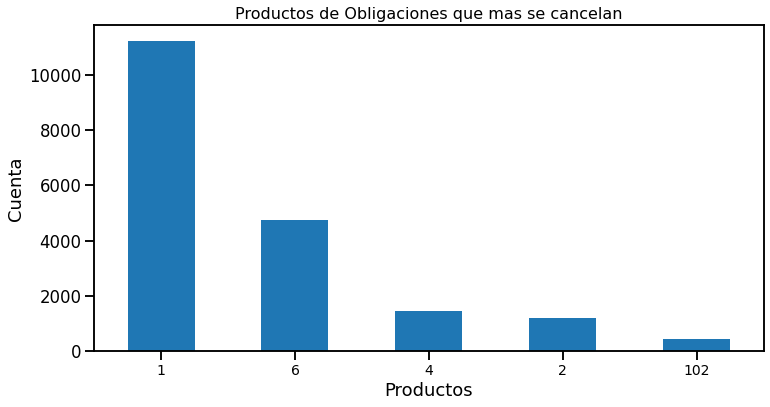

In [40]:
m19_df_C = m19_df_obn[m19_df_obn.estado == 'C']

plt.figure(figsize = (12,6))
m19_df_C.obn_producto.value_counts().head(5).plot(kind="bar")
plt.xticks(rotation = 0, fontsize = 14)
plt.xlabel("Productos")
plt.ylabel("Cuenta")
plt.title('Productos de Obligaciones que mas se cancelan',fontsize = 16)
plt.ticklabel_format(axis="y", style="plain")

most_C_prod = m19_df_C.obn_producto.value_counts().to_frame().reset_index()\
                .rename({'index': 'obn_producto', 'obn_producto': 'count'}, axis='columns')

In [41]:
most_C_prod

,obn_producto,count
0,1,11234
1,6,4762
2,4,1465
3,2,1214
4,102,432
5,3,292
6,33,195
7,103,165
8,28,53
9,106,44


### Correlacion monto de deuda y cantidad de gestiones

Correlacion monto de deuda y cantidad de gestiones
CORR= 0.05096928686931513
COV = 124184.9539892623 


Text(0.5, 0, 'Monto de deuda')

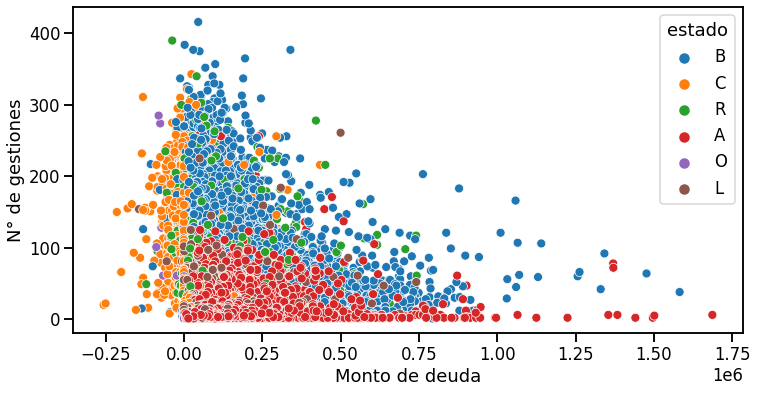

In [42]:
plt.figure(figsize = (12,6))
sns.scatterplot(data=m19_df_obn[m19_df_obn['monto_deuda']<7e6], x= 'monto_deuda',y='count_gestion', hue='estado')
print(f'Correlacion monto de deuda y cantidad de gestiones\n\
CORR= {m19_df_obn.monto_deuda.corr(m19_df_obn.count_gestion)}\n\
COV = {m19_df_obn.monto_deuda.cov(m19_df_obn.count_gestion)} ')
plt.ylabel('N° de gestiones')
plt.xlabel('Monto de deuda')

Text(0.5, 0, 'Monto de deuda')

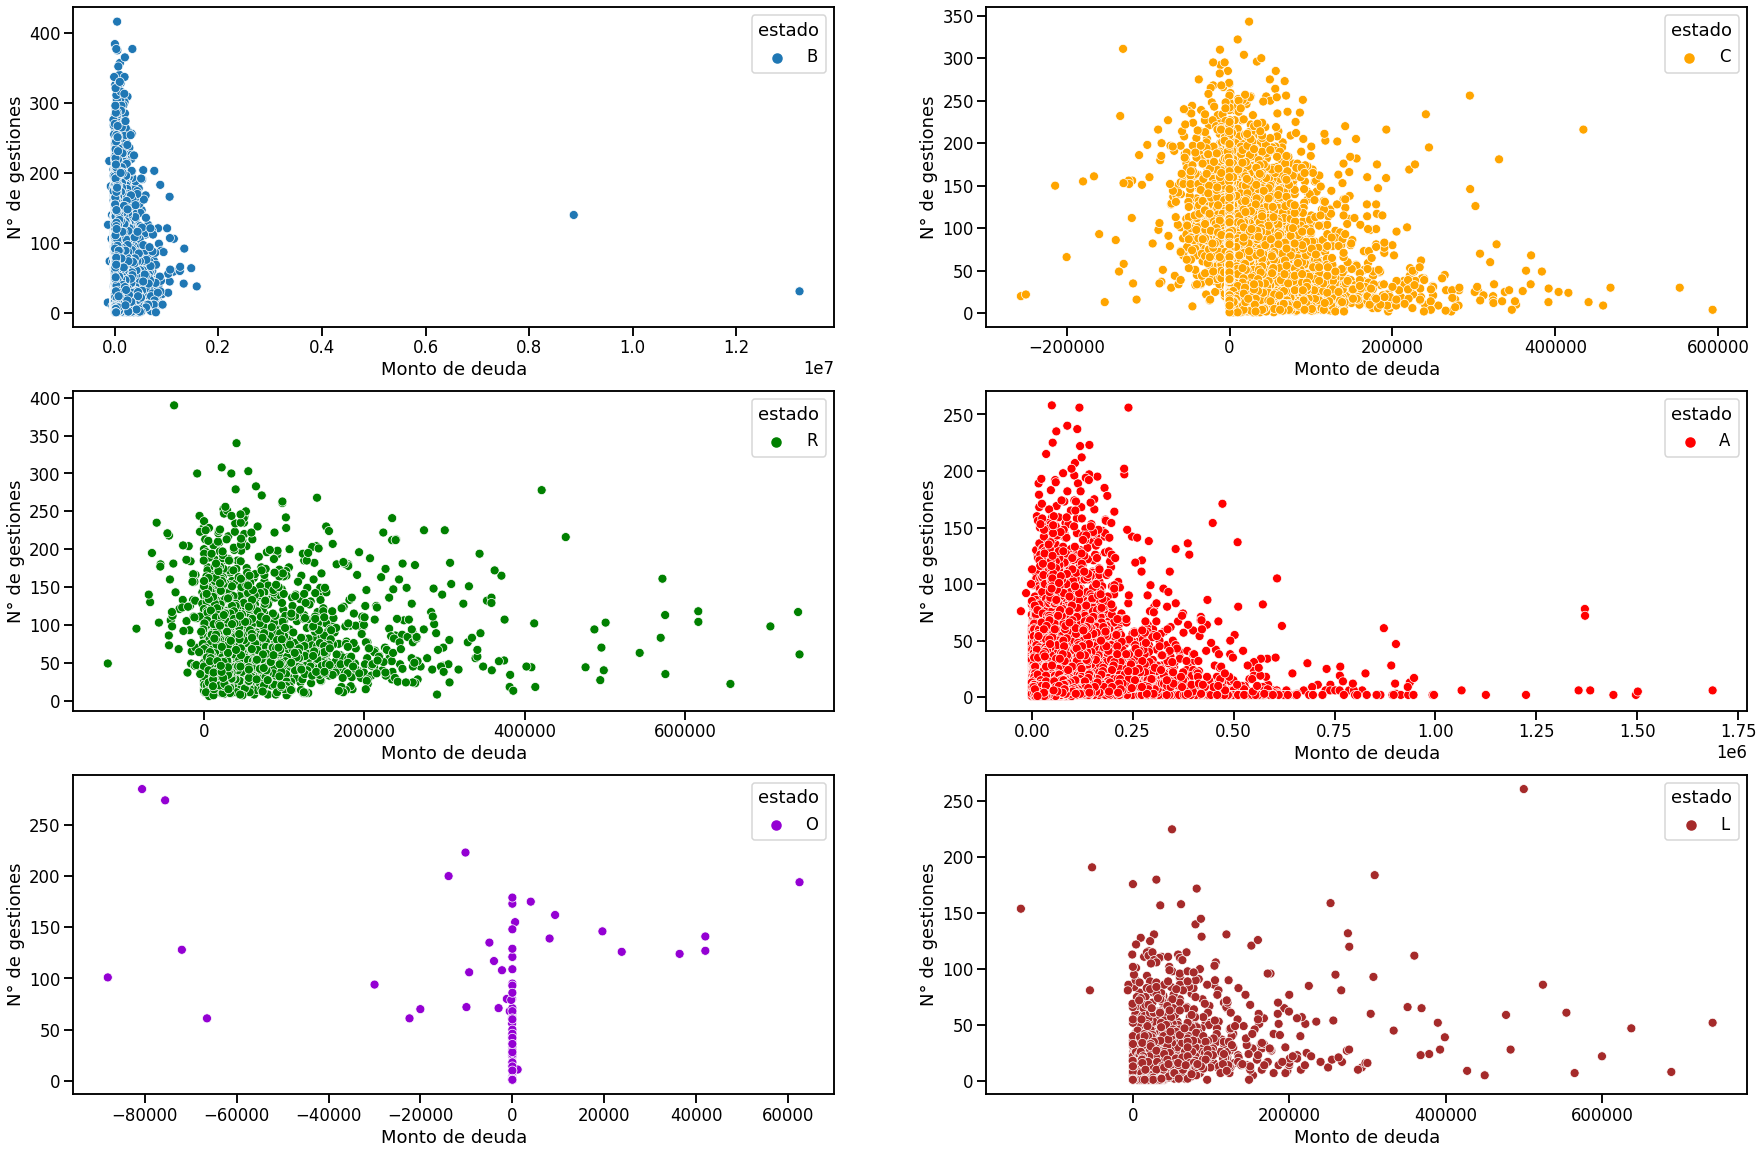

In [43]:
fig, axs = plt.subplots(3,2,figsize=(30, 20))

sns.scatterplot(data=m19_df_obn[(m19_df_obn['estado']=='B')], x= 'monto_deuda',y='count_gestion',\
                hue='estado', ax=axs[0,0]) 
axs[0,0].set_ylabel('N° de gestiones')
axs[0,0].set_xlabel('Monto de deuda')

sns.scatterplot(data=m19_df_obn[m19_df_obn['estado']=='C'], x= 'monto_deuda',y='count_gestion',\
                hue='estado', ax=axs[0,1], palette=['orange'])
axs[0,1].set_ylabel('N° de gestiones')
axs[0,1].set_xlabel('Monto de deuda')

sns.scatterplot(data=m19_df_obn[m19_df_obn['estado']=='R'], x= 'monto_deuda',y='count_gestion',\
                hue='estado', ax=axs[1,0], palette=['green'])
axs[1,0].set_ylabel('N° de gestiones')
axs[1,0].set_xlabel('Monto de deuda')

sns.scatterplot(data=m19_df_obn[m19_df_obn['estado']=='A'], x= 'monto_deuda',y='count_gestion',\
                hue='estado', ax=axs[1,1], palette=['red'])
axs[1,1].set_ylabel('N° de gestiones')
axs[1,1].set_xlabel('Monto de deuda')

sns.scatterplot(data=m19_df_obn[m19_df_obn['estado']=='O'], x= 'monto_deuda',y='count_gestion',\
                hue='estado', ax=axs[2,0], palette=['darkviolet'])
axs[2,0].set_ylabel('N° de gestiones')
axs[2,0].set_xlabel('Monto de deuda')

sns.scatterplot(data=m19_df_obn[m19_df_obn['estado']=='L'], x= 'monto_deuda',y='count_gestion',\
                hue='estado', ax=axs[2,1], palette=['brown']) 
axs[2,1].set_ylabel('N° de gestiones')
axs[2,1].set_xlabel('Monto de deuda')

No se observan correlacion o un tipo de comportamiento especifico entre las cantidades de gestiones y los montos de deudas segun  los tipos de estados. Si se observa que hay covarianza positiva, es decir que a mayores montos de deuda la cantidad de gestiones aumenta.